<h1 style="text-align: center;" markdown="3">Machine Learning 0: Baseline Model</h1> 

# Table of Contents
[Introduction](#introduction)  
[Unbalanced vs Balanced Datasets](#unbalanced-intro)    
[Evaluate with Metrics](#metrics)        
[Baseline Model](#baseline) 

# Introduction <a class="anchor" id="introduction"></a>

In order to compare our results, it is important to create a baseline model. We will simply take the majority of the cases and define them as a base. We will therefore simulate a dummy classifier that predicts '0' with a 50% probability for everything.

Let's first import the data and load the libraries.

In [1]:
# Data importation and manipulation tools
import json
import numpy as np
import pandas as pd
import itertools

# Data visualization tools
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Machine Learning tools
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    log_loss,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_curve,
    auc
)

In the pre-processing notebook we should have cleaned and organized the data already, so we should simply have to import our pre-processed files. For applying the algorithm, we'll need the features, weights, and labels. To make things more understandable for the analysis/evaluation, we'll also want to load the file that contains the questions associated with each feature.

Data to load: 
- train.pkl -> `X_train`, `y_train`, `w_train`
- questions.json -> `questions`

In [2]:
# load text of survey questions for reference
with open("Data/processed/questions.json", 'r') as fp:
    questions = json.load(fp)

# load training data 
lcs_train = pd.read_pickle("Data/processed/train.pkl")

# Separate features
X_train = lcs_train.drop(['Persns_wgt', 'sick'], axis=1)
y_train = lcs_train['sick']
w_train = lcs_train['Persns_wgt']

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent sick: {:0.1%} \tPercent non-sick: {:0.1%}' \
        .format(*y_train.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 39,075 rows and 236 columns
Percent sick: 15.9% 	Percent non-sick: 84.1%


,Q14AGE,Q613BED,Q615KITCHEN,Q616BATH,Q617TOILET,Q161APUBATT,Q161APRIVATT,hhsize,expenditure_pcp,pcnetincome,...,Q221DHEALTH__More than adequate,Q224ANOMONEY__Yes,Q224BNOMONEY5__Yes,Q225ASIZE__Yes,Q225BSIZE5__Yes,Q226ASKIP__Yes,Q226BSKIP5__Yes,Q227ALESS__Yes,Q227BLESS5__Yes,SexOfHead__Male
UQNO,,,,,,,,,,,,,,,,,,,,,
920002240000007301,48,2,0,0,0,0,0,5,3664.148804,400,...,0,0,0,0,0,0,0,0,0,1
417000450000011901,27,0,0,0,0,0,0,4,11451.292500,1250,...,0,0,0,0,0,1,0,1,0,1
107002150000030901,3,1,1,0,0,3,0,6,6066.745258,1000,...,0,1,0,1,0,1,0,1,0,1
919005240000017601,0,1,1,1,0,0,0,3,28007.446415,2620,...,0,0,0,0,0,0,0,0,0,1
983000120000022201,4,3,1,0,0,0,0,7,1727.626033,285,...,0,0,0,0,0,0,0,0,0,0


# Unbalanced vs Balanced Datasets <a class="anchor" id="unbalanced-intro"></a>

As we see above, our data are unbalanced. This means that there are much fewer examples of "sick" individuals. If we were only using classification accuracy as a metric (The number of correct predictions), this means that we could simply predict that every individual is healthy and have a model with 84% accuracy (our baseline). However, this would obviously not help us reach our goals for actually understanding and predicting sickness in South Africa. We will see later how we try to address this issue, but for now, let's simulate our baseline model.

In [3]:
# Load and transform the test set
lcs_test = pd.read_pickle("Data/processed/test.pkl")
y_test = lcs_test['sick']

# Predict everything as 'non-poor', with 50% probability
y_pred = np.zeros(len(y_test))
y_prob = np.ones(len(y_test)) * 0.5

# Evaluate with metrics  <a class="anchor" id="metrics"></a>
There are many ways to evaluate the performance of a machine learning model. Some are more applicable to specific models than others, so it is sometimes better to look at many metrics to get a realistic feel for how the model performs.

To make the model evaluation process easier and to ensure we are evaluating them in a standardized way, we define several functions to calculate and visualize the metrics.

In [4]:
# Create the ROC plot function
def plot_roc(y_test, y_pred, y_prob, model, ax, sample_weights=None):
    
    # dictionnary of metrics to calculate
    fpr, tpr, _ = roc_curve(y_test, y_prob, sample_weight=sample_weights)
    metrics = {}
    metrics['fpr'] = fpr
    metrics['tpr'] = tpr
    metrics['roc_auc'] = roc_auc_score(y_test,y_prob, sample_weight=sample_weights)
    
    # Create graph with Legend
    ax= ax
    ax.plot(metrics['fpr'], metrics['tpr'], label='{} AUC = {:0.2f}'.format(model, metrics['roc_auc']))
    
    # Specification of Graph
    ax.set_title('Receiver Operating Characteristic')
    ax.plot([0,1],[0,1],'k--')
    ax.set_xlim([-0.01,1])
    ax.set_ylim([0,1.01])
    ax.legend(loc='lower right')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    return

# Create the confusion matrix plot function
# Derived from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_test, y_pred,ax, sample_weight = None):
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, sample_weight=None)
    # Reverse the results
    cm = cm[::-1,::-1]

    # Create plot
    ax = ax
    tick_marks = np.arange(2)
    ax.set_title('Confusion matrix')
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(["sick", "non-sick"])
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(["sick","non-sick"])
    ax.grid(False)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    # Create font and color bar
    im = ax.imshow(cm, interpolation='nearest', cmap= plt.cm.Blues)
    fig.colorbar(im, ax=ax, shrink=0.7)

    # Create normalized and text results
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt = "{:.0f}".format(cm[i,j])
        txt = txt + "\n{:0.1%}".format(cm_norm[i,j])
        ax.text(j, i, txt, fontsize=14, fontweight='bold',
                     horizontalalignment="center", verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    return


# Create a DataFrame to store de model results
model_score = pd.DataFrame(index = ['accuracy','recall','precision','f1','roc_auc','cross_entropy','cohen_kappa'])

# Define a function to show metrics in a DataFrame
def get_metrics(y_test, y_pred, model_name, sample_weights=None): 
    # Show metrics values
    model_scores = {}

    model_scores['accuracy']          = accuracy_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['recall']            = recall_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['precision']         = precision_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['f1']                = f1_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['roc_auc']           = roc_auc_score(y_test,y_prob, sample_weight=sample_weights)
    model_scores['cross_entropy']     = log_loss(y_test,y_prob,sample_weight=sample_weights)
    model_scores['cohen_kappa']       = cohen_kappa_score(y_test, y_pred)

    print("Model Scores")
    print("Actual sick rate: {:0.2%}".format(y_test.sum()/len(y_test)))
    print("Predicted sick rate: {:0.2%}".format(y_pred.sum()/len(y_pred)))
    model_score[model_name] = model_score.index.map(model_scores)
    return model_score

# Baseline Model <a class="anchor" id="baseline"></a>

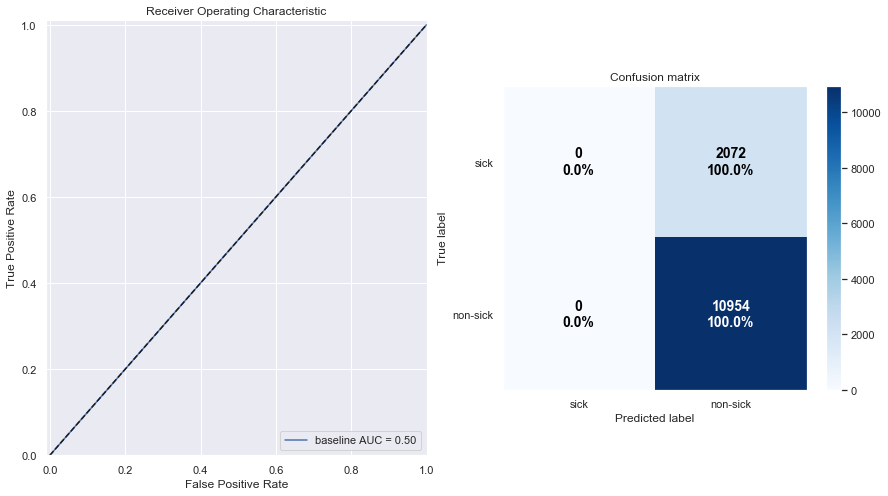

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 0.00%


/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,baseline
accuracy,0.840934
recall,0.000000
precision,0.000000
f1,0.000000
roc_auc,0.500000
cross_entropy,0.693147
cohen_kappa,0.000000


In [5]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "baseline", ax= axes[0])
plot_confusion_matrix(y_test, y_pred, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred, 'baseline')

As we predicted, the classifier gives us an accuracy of around 84%, but we can see pretty clearly from the other metrics that it is not performing well. This is one reason why accuracy is not the only metric we use to evaluate the performance of a model. In the case of health prediction, we may be more concerned with having a high recall, which in this case is the fraction of 'sick' individuals we predict correctly as 'sick' over the total number of actual 'sick' individuals.

# Metrics description
We have many metrics above. In order to better understand how our model performs, it is wise to remember in basic terms what each metric represents.


- __Accuracy:__  The accuracy is the correctly predicted class over the total testing class. __(TN + TP) / Total.__

- __Recall:__ The recall is the ability of a model to find all the relevant cases (sick people) within a data set. __TP / (TP + FN)__

- __Precision:__ The precision measure the proportion of correctly predicted sick people over the total predicted sick people __TP / (TP + FP)__

- __f1:__ The f1 score is a function of Precision and Recall if we seek a balance between Precision and Recall. __2*Precision * Recall / (Precision + Recall)__

- __roc_auc:__ Receiver Operator Characteristic (ROC) is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

- __cross_entropy:__ The cross-entropy is the log-loss function.

- __cohen_kappa:__ The cohen-kappa metrics is a more robust way of measuring accuracy. This normalizes the classification accuracy by the imbalance of the classes in the data.

In [6]:
# Store the results in a pickle file
# Save data to files
model_score.to_pickle("models/baseline.pkl")